## Problem Statement: 

Natural incidents occur on a daily basis, however only a subsection of those qualify as disasters. Those disasters can be reported via a variety of sources. The employees that need to be responding to these incidents do not have the time to do that and manually monitor and sift through all incoming information. We want to provide a way to alert these employees to relevant disasters allowing them to marshal the necessary.
 


## Load libraries:

#### We need to import the libraries and packages as follows:

- pandas
- numpy
- seaborn
- regex
- json
- nltk
- matplotlib.pyplot

- train_test_split from sklearn's model_selection module
- cross_val_score from sklearn's model_selection module
- GridSearchCV from sklearn's model_selection module
- Pipeline from sklearn's pipeline module
- LogisticRegression from sklearn's linear_model module
- KNeighborsClassifier from sklearn's neighbors module
- DecisionTreeRegressor from sklearn's tree module
- DecisionTreeClassifier from sklearn's tree module

- BaggingRegressor from sklearn's ensemble module
- BaggingClassifier from sklearn's ensemble module
- RandomForestClassifier from sklearn's ensemble module
- ExtraTreesClassifier from skearn's ensemble module
- GradientBoostingClassifier from sklearn's ensemble module 
- AdaBoostClassifier from sklearn's ensemble module

- text from sklearn's feature_extraction module
- CountVectorizer from sklearn's feature_extraction.text module
- TfidfVectorizer from sklearn's feature_extraction.text module
- MultinomialNB from sklearn's naive_bayes module
- TruncatedSVD from sklearn's decomposition module 

- confusion_matrix from sklearn's metrics module
- roc_auc_score from sklearn's metrics module
- f1_score from sklearn's metrics module
- cosine_similarity from sklearn's metrics.pairwise module 

- BeautifulSoup from bs4 module
- stopwords from nltk's corpus module
- WordNetLemmatizer from nltk's stem module
- PorterStemmer from nltk's stem.porter module
- RegexpTokenizer from nltk's tokenize module

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import json
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity

from bs4 import BeautifulSoup  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

np.random.seed(42)

%matplotlib inline

/Users/kennethlee/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load, analyze and pre-process flood dataset. 

In [2]:
df = pd.read_csv('../datasets/floods_relevance.csv')

In [3]:
print(df.shape)
df.head()

(1000, 6)


,content,description,publishedAt,title,source_name,flood_relevance
0,Chat with us in Facebook Messenger. Find out w...,A pair of environmental reports reveal the wor...,2019-01-16T22:52:24Z,Melting ice could flood Brooklyn Bridge,CNN,0
1,The aid group said it had seen hundreds of cas...,With vast areas submerged by contaminated wate...,2019-03-27T15:49:20Z,Cholera Outbreak Raises New Danger in Flood-Ra...,The New York Times,0
2,Finding settings that amplify an operas drama ...,"From left: Kristine Flood, Wanda Ferrerias, Ma...",2018-12-04T17:05:05Z,"After Struggling With Homelessness, a Chorus S...",The New York Times,0
3,"The amount the ground can soak up is limited, ...","Flooding in the town of Hamburg, Iowa, on Marc...",2019-04-08T20:58:04Z,Powerful Storm Threatens More Misery in Flood-...,The New York Times,1
4,"Many of the levees, usually earthen and topped...",Hundreds of miles of levees in the Midwest hav...,2019-03-31T09:00:10Z,"‘Breaches Everywhere’: Midwest Levees Burst, a...",The New York Times,0


### What is our baseline accuracy?

In [4]:
df.drop(columns=['publishedAt','source_name'], inplace=True)
df.rename(columns={'flood_relevance':'positive'}, inplace=True)
# Baseline Accuracy 
df['positive'].value_counts(normalize=True)

0    0.634
1    0.366
Name: positive, dtype: float64

In [5]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['content'].replace('\d+', ' ', regex=True, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,content,description,title,positive
0,0,Chat with us in Facebook Messenger. Find out w...,A pair of environmental reports reveal the wor...,Melting ice could flood Brooklyn Bridge,0
1,1,The aid group said it had seen hundreds of cas...,With vast areas submerged by contaminated wate...,Cholera Outbreak Raises New Danger in Flood-Ra...,0
2,2,Finding settings that amplify an operas drama ...,"From left: Kristine Flood, Wanda Ferrerias, Ma...","After Struggling With Homelessness, a Chorus S...",0
3,3,"The amount the ground can soak up is limited, ...","Flooding in the town of Hamburg, Iowa, on Marc...",Powerful Storm Threatens More Misery in Flood-...,1
4,4,"Many of the levees, usually earthen and topped...",Hundreds of miles of levees in the Midwest hav...,"‘Breaches Everywhere’: Midwest Levees Burst, a...",0


### Use TF-IDF Vectorizer to vectorize the dataset for preliminary analysis:

In [6]:
stop_words = text.ENGLISH_STOP_WORDS.union('playing', 
                                           'said', 
                                           'Image', 
                                           'copyright', 
                                           'Media', 
                                           'caption')
stop = list(text.ENGLISH_STOP_WORDS)
stop.extend(['playing','said', 'Image', 'copyright', 'Media', 'caption'])

tvec = TfidfVectorizer(stop_words=stop, 
                       min_df=5, 
                       max_df=1.0, 
                       ngram_range=(1,2), 
                       max_features=5000)

# Other option:
# tvec1=TfidfVectorizer(stop_words=stop, min_df=5, max_df=1.0, max_features=1000)

In [7]:
cont_mat = tvec.fit_transform(df['content'])
cont_mat.shape
len(tvec.get_feature_names())
cont_df = pd.SparseDataFrame(cont_mat, columns=tvec.get_feature_names())
cont_df.fillna(0, inplace=True)

In [8]:
cont_df.head()

,___,abandoned,abc,abc news,ability,able,abortion,abroad,absence,absolutely,...,youtube,yuan,zealand,zero,zimbabwe,zimbabwe malawi,zone,zones,zookeeper,zookeeper struck
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.104423,0.10894,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0


In [9]:
svd = TruncatedSVD(n_components=100)
svd_matrix = svd.fit_transform(cont_df)
svd_matrix.shape

(958, 100)

## Load and Transform new Flood Articles

In [10]:
df3 = pd.read_csv('../datasets/flood_articles1.csv')

In [11]:
df3.shape

(131, 6)

### Clean data

In [12]:
df3.drop_duplicates(inplace=True)
df3.dropna(inplace=True) 
df3['content'].replace('\d+', ' ', regex=True, inplace=True)
df3.reset_index(inplace=True)
df3.head()

,index,content,description,publishedAt,title,source_name,flood_disaster_relevance
0,0,Image copyright EPA Image caption Locals have ...,Cyclone Owen has been downgraded to a tropical...,2018-12-15T23:02:13Z,"Cyclone Owen downgraded, but could reform off ...",BBC News,0
1,1,Image copyright Reuters Italy has been battere...,Images of Venice under flood waters as at leas...,2018-10-30T09:46:20Z,Venice under water as Italy hit by fierce wind...,BBC News,0
2,2,Image copyrightADDY TRITT\r\nSeveral Midwester...,As devastating flooding continues to affect th...,2019-04-03T17:28:59Z,Woman buys out shoe store to help flood victims,BBC News,0
3,3,Image copyrightAFPImage caption\r\n A man inju...,The tropical cyclone took governments by surpr...,2019-03-24T00:23:07Z,Cyclone Idai: How prepared was southern Africa?,BBC News,0
4,4,Media captionThousands of homes destroyed as I...,"Floods have already killed at least 70 people,...",2019-04-06T07:57:14Z,Iran floods: Thousands evacuate homes as heavy...,BBC News,1


### Transform Flood Articles

In [13]:
cont_mat3 = tvec.transform(df3['content'])
cont_mat3.shape
len(tvec.get_feature_names())
cont_df3 = pd.SparseDataFrame(cont_mat3, columns=tvec.get_feature_names())
cont_df3.fillna(0, inplace=True)

In [14]:
svd_test = svd.transform(cont_df3)
svd_test.shape

(127, 100)

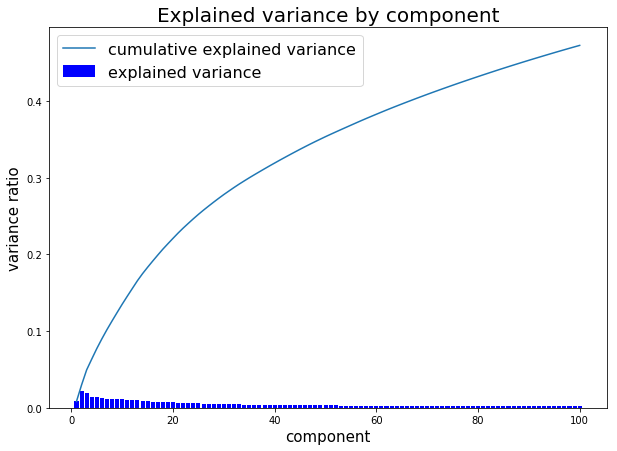

In [15]:
# Plot explained variance components for all SVD components
fig = plt.figure(figsize=(10,7))
plt.bar(np.array(range(100))+1, 
        svd.explained_variance_ratio_, 
        color='blue', 
        label='explained variance')
plt.plot(np.array(range(100))+1, 
         np.cumsum(svd.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=15)
plt.ylabel('variance ratio', fontsize=15)
plt.title('Explained variance by component', fontsize=20)
plt.savefig ('Explained_variance.png')

### Convert SVD Matrix into a DataFrame

In [16]:
svd_df_t = pd.DataFrame(svd_matrix)
svd_df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.028429,-0.031511,-0.020558,-0.005524,-0.003327,0.007197,-0.005791,0.015838,-0.011433,0.006704,...,-0.015783,-0.018926,-0.005016,-0.008434,0.009845,0.002049,-0.006915,0.023666,0.007419,0.010974
1,0.145730,-0.061304,-0.096387,-0.087204,-0.035887,-0.039392,0.011411,-0.018362,-0.002185,-0.025032,...,-0.058153,-0.047370,-0.068308,0.011764,-0.020070,-0.002666,0.050876,0.098896,0.020429,-0.108397
2,0.104839,-0.106565,-0.034478,0.011721,0.002804,0.030565,-0.017831,0.001127,-0.000850,0.001335,...,0.018532,0.046139,-0.042905,-0.004947,-0.027232,0.035714,-0.027936,-0.017700,-0.021135,0.036531
3,0.242333,0.060956,-0.070342,0.003449,-0.003113,-0.011373,0.014745,0.012114,-0.043479,-0.016919,...,0.067344,-0.022886,-0.113300,-0.085245,-0.024793,0.023810,-0.014143,0.016860,0.022708,0.089868
4,0.198671,-0.062792,-0.153314,-0.139669,-0.056545,-0.111540,0.037088,0.000808,-0.005873,-0.026059,...,-0.011834,0.018059,-0.061912,-0.004865,0.030342,-0.053840,-0.017257,0.005844,0.006185,0.012723


In [17]:
# Turn SVD matrix into a DataFrame:
comp_names = ['component_'+str(i+1) for i in range(100)]
svd_df = pd.DataFrame(svd_matrix, columns=comp_names)
svd_df.shape

(958, 100)

In [18]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,0.028429,-0.031511,-0.020558,-0.005524,-0.003327,0.007197,-0.005791,0.015838,-0.011433,0.006704,...,-0.015783,-0.018926,-0.005016,-0.008434,0.009845,0.002049,-0.006915,0.023666,0.007419,0.010974
1,0.145730,-0.061304,-0.096387,-0.087204,-0.035887,-0.039392,0.011411,-0.018362,-0.002185,-0.025032,...,-0.058153,-0.047370,-0.068308,0.011764,-0.020070,-0.002666,0.050876,0.098896,0.020429,-0.108397
2,0.104839,-0.106565,-0.034478,0.011721,0.002804,0.030565,-0.017831,0.001127,-0.000850,0.001335,...,0.018532,0.046139,-0.042905,-0.004947,-0.027232,0.035714,-0.027936,-0.017700,-0.021135,0.036531
3,0.242333,0.060956,-0.070342,0.003449,-0.003113,-0.011373,0.014745,0.012114,-0.043479,-0.016919,...,0.067344,-0.022886,-0.113300,-0.085245,-0.024793,0.023810,-0.014143,0.016860,0.022708,0.089868
4,0.198671,-0.062792,-0.153314,-0.139669,-0.056545,-0.111540,0.037088,0.000808,-0.005873,-0.026059,...,-0.011834,0.018059,-0.061912,-0.004865,0.030342,-0.053840,-0.017257,0.005844,0.006185,0.012723


In [19]:
comp_names = ['component_'+str(i+1) for i in range(100)]
svd_df3 = pd.DataFrame(svd_test, columns=comp_names)
svd_df3.shape

(127, 100)

In [20]:
svd_df3c = svd_df3

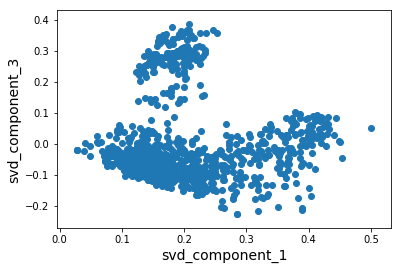

In [21]:
plt.scatter(svd_df.component_1, svd_df.component_3)
plt.xlabel('svd_component_1', fontsize=14)
plt.ylabel('svd_component_3', fontsize=14);

## Explore the Single Value Decomposition Data

In [22]:
print(svd.components_.shape)
svd.components_

(100, 5000)


array([[ 4.97109099e-03,  3.89236146e-03,  1.68922378e-02, ...,
         4.25590039e-03,  5.12416023e-03,  3.76188636e-03],
       [-6.79233464e-04, -4.59603698e-03,  1.36517434e-02, ...,
        -4.81554103e-04, -1.00112806e-02, -7.32853698e-03],
       [-3.04044079e-03, -5.40779064e-04,  1.02161886e-03, ...,
        -3.36395745e-03,  2.30935701e-02,  1.69529044e-02],
       ...,
       [ 3.63630793e-03,  3.10161244e-03,  1.44641093e-02, ...,
         2.39544341e-04,  4.00846185e-03, -9.50014936e-04],
       [-3.72663639e-04,  1.98139373e-04, -1.24543500e-02, ...,
         6.09953113e-03, -1.11810462e-02, -4.80941582e-03],
       [ 3.45068430e-03,  1.14404425e-02,  1.70798719e-02, ...,
         7.72747244e-03,  5.73661702e-03, -3.39784837e-05]])

In [23]:
loadings = pd.DataFrame(svd.components_, index=comp_names, columns=cont_df.columns).T

In [24]:
loadings.head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
___,0.004971,-0.000679,-0.003040,-0.003561,-0.001734,-0.001884,0.001508,-0.001761,0.003392,0.001387,...,0.003043,-0.005315,-0.007016,-0.007882,0.001540,0.007452,-0.004630,0.003636,-0.000373,0.003451
abandoned,0.003892,-0.004596,-0.000541,-0.000897,-0.001050,0.001392,-0.000796,0.000439,0.001585,0.001898,...,-0.012183,-0.000290,-0.001438,0.000627,0.000466,-0.008921,0.001218,0.003102,0.000198,0.011440
abc,0.016892,0.013652,0.001022,0.019154,0.009141,0.013222,-0.006626,0.003874,-0.004291,0.009344,...,0.011688,-0.010914,-0.011784,-0.039827,0.041632,0.012457,-0.019480,0.014464,-0.012454,0.017080
abc news,0.015520,0.017072,0.001638,0.019479,0.009808,0.013226,-0.003962,0.005006,-0.002280,0.006415,...,0.012512,-0.003447,-0.007691,-0.009479,0.031473,0.016141,-0.017207,0.015534,-0.010580,0.000538
ability,0.005332,-0.005416,-0.003754,0.003603,-0.000298,0.003905,-0.000735,0.001720,0.000723,0.001344,...,0.009428,-0.003882,0.002744,-0.000420,-0.000791,-0.003615,0.006703,0.005984,0.002997,-0.003064
able,0.019723,-0.019806,-0.004233,-0.009947,-0.007184,-0.000034,-0.004373,0.002613,-0.007609,0.012142,...,0.005198,-0.008714,-0.007864,-0.017879,0.001457,-0.017167,0.005621,0.013862,0.014550,0.028503
abortion,0.003526,-0.006844,-0.003560,0.002347,-0.000862,0.002883,-0.001684,0.001502,0.000379,0.001258,...,-0.020772,-0.018625,0.020858,0.040541,-0.028268,-0.021324,-0.008424,-0.054052,0.015829,-0.024460
abroad,0.003858,-0.004014,-0.005918,-0.005860,-0.003106,-0.003362,0.000443,-0.002529,-0.001422,-0.001270,...,-0.002059,0.002943,-0.006951,0.002301,0.009027,-0.004801,0.008037,-0.001215,-0.013204,0.015116
absence,0.005280,-0.005382,0.006131,0.005350,-0.000294,-0.003714,-0.029280,-0.031255,-0.007078,-0.019081,...,-0.000518,0.009978,-0.002623,0.005555,-0.008232,-0.006064,-0.004176,0.011293,-0.002810,0.009481
absolutely,0.003185,-0.004141,-0.003301,0.002678,0.000222,0.001668,-0.000410,0.001028,-0.000066,0.000074,...,-0.001189,-0.005181,-0.001499,0.000140,0.003401,-0.007967,0.002277,0.006761,0.004668,-0.000853


In [25]:
loadings['component_2_abs'] = np.abs(loadings['component_2'])

In [26]:
loadings.sort_values('component_1', ascending=False)['component_1'].head(20)

rain          0.178262
snow          0.162953
storm         0.161420
flooding      0.127096
weather       0.126887
inches        0.118378
people        0.110871
river         0.101504
heavy         0.100614
new           0.097735
trump         0.097261
water         0.095494
california    0.094935
flood         0.087606
nebraska      0.083761
thursday      0.083737
morning       0.082803
areas         0.081431
year          0.081242
friday        0.079965
Name: component_1, dtype: float64

In [27]:
loadings.sort_values('component_3', ascending=False)['component_2'].head(20)

woman             -0.054716
police            -0.060450
murder            -0.036421
year old          -0.056000
teen              -0.038144
crash             -0.036373
california         0.014928
old               -0.059672
death             -0.046452
killing           -0.037224
news headlines    -0.028764
headlines today   -0.028764
man               -0.048334
suspect           -0.023583
headlines         -0.028778
car               -0.025896
mom               -0.032635
arrested          -0.030022
officer           -0.032467
storm              0.173950
Name: component_2, dtype: float64

### Plot of selected Principal Component Loadings : relative proportion of words for components

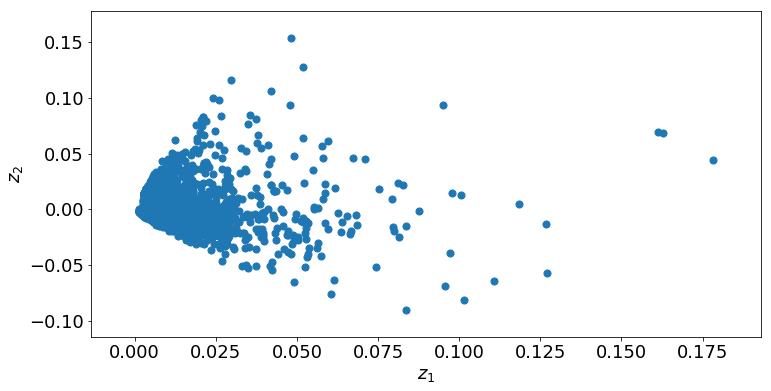

In [28]:
ax = loadings.plot(kind="scatter", x="component_1", y="component_3", figsize=(12,6), s=50)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

In [29]:
svd_df3.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,0.239293,0.090569,-0.040467,-0.038120,-0.019326,-0.021398,0.018319,-0.014187,-0.015235,0.001726,...,-0.004184,0.031788,-0.011673,0.022609,-0.024179,-0.009037,0.013185,-0.000381,-0.001727,0.044531
1,0.126211,-0.000837,-0.050894,-0.063046,-0.018469,-0.030258,0.017673,-0.007006,0.003743,-0.006019,...,0.004570,-0.038182,0.009187,0.000263,0.015878,-0.011217,0.032179,0.009951,-0.019282,-0.007620
2,0.223225,-0.082331,-0.097539,-0.119526,-0.066894,-0.066701,0.033703,-0.010850,0.004964,-0.032958,...,-0.010904,-0.027449,0.023091,-0.018197,-0.038260,-0.029152,0.017736,-0.003019,-0.039695,0.015348
3,0.235153,-0.010210,-0.092211,-0.093262,-0.025146,-0.043776,0.001470,-0.006067,-0.016245,-0.024396,...,0.012525,0.018823,-0.002485,0.000835,-0.027099,-0.004025,0.000396,-0.015071,0.016626,0.031077
4,0.264596,-0.053239,-0.127797,-0.119430,-0.063109,-0.067272,-0.005702,-0.039083,0.007259,0.003880,...,0.029847,-0.017893,0.006374,0.027191,-0.007115,0.016203,-0.042977,-0.005661,0.002965,0.062976


## Try fitting kNN

In [30]:
# this was commented out after initial 
# # Find the best n-neighbor denoted as k to fit kNN
# knn0 = KNeighborsClassifier()
# knn0_params = {
#     'n_neighbors':[3, 5, 7, 9, 11],
#     'metric':['minkowski','euclidean','manhattan'],
#     #'max_features':['auto', 4, 5],  # default is sqrt(9)= 3 features per tree
#     #'min_samples_split':[3, 5, 7]
#               }

# gs = GridSearchCV(knn0, param_grid=knn0_params, cv=5)
# # Trying our all param combinations, 
# # for each combo, we'r doing a 5 fold cv
# # use the best params and fit to the entire training data
# gs.fit(X_train, y_train)
# print(gs.best_score_)  # Cross val score, from best_params_
# print(gs.best_params_) # best parameters: Minkowski metric with n neighbors 7

### Model Preparation

In [31]:
# Create feature matrix X and target vector y
X = df['content']
y = df['positive']

In [32]:
# Prepare Train/Test split
X_train, X_test, y_train, y_test = train_test_split(svd_df, y, stratify=y) # test_size=0.25
                                                                           # by default

### Model Instantiation and Evaluations

In [33]:
# Instantiate kNN with n_neighbors 7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
# Evaluate model
print(f'k Nearest Neighbors (with k=7) Train Score: {knn.score(X_train, y_train)}')
print(f'k Nearest Neighbors (with k=7) Test Score: {knn.score(X_test, y_test)}')

k Nearest Neighbors (with k=7) Train Score: 0.862116991643454
k Nearest Neighbors (with k=7) Test Score: 0.8333333333333334


In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [35]:
preds = knn.predict(svd_df)     # predictions of single value decomposition flood relevance 
preds3 = knn.predict(svd_df3)   # predictions of single value decomposition flood articles 
df['preds'] = preds
df3['preds3'] = preds3

In [36]:
y3 = df3['flood_disaster_relevance']

In [37]:
# Compute F1 scores, weighted average of the precision and recall
print(f'Total Score: { f1_score(preds, y)}') # F1 score for flood relevance
print(f'Total Score: { f1_score(preds3, y3)}') # F1 score for flood articles

Total Score: 0.7952871870397643
Total Score: 0.6428571428571429


In [38]:
# Construct confusion matrix for predicted flood relevance
cm = confusion_matrix(y, preds)
cm_df = pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'],
                  index= ['actual_neg', 'actual_pos'])
cm_df

,pred_neg,pred_pos
actual_neg,549,61
actual_pos,78,270


In [39]:
tn, fp, fn, tp = confusion_matrix(y, preds).ravel()
(tn, fp, fn, tp)


(549, 61, 78, 270)

In [40]:
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.8157099697885196
recall:  0.7758620689655172


In [41]:
# Construct confusion matrix for predicted flood articles
cm3 = confusion_matrix(y3, preds3)
cm_df3 = pd.DataFrame(cm3, columns=['pred_neg', 'pred_pos'],
                      index=['actual_neg', 'actual_pos'])
cm_df3

,pred_neg,pred_pos
actual_neg,108,10
actual_pos,0,9


In [42]:
tn, fp, fn, tp = confusion_matrix(y3, preds3).ravel()
(tn, fp, fn, tp)

(108, 10, 0, 9)

In [43]:
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.47368421052631576
recall:  1.0


In [46]:
#df3[df3['flood_disaster_relevance']==1]

In [44]:
df3[df3['preds3'] == 1]

,index,content,description,publishedAt,title,source_name,flood_disaster_relevance,preds3
0,0,Image copyright EPA Image caption Locals have ...,Cyclone Owen has been downgraded to a tropical...,2018-12-15T23:02:13Z,"Cyclone Owen downgraded, but could reform off ...",BBC News,0,1
3,3,Image copyrightAFPImage caption\r\n A man inju...,The tropical cyclone took governments by surpr...,2019-03-24T00:23:07Z,Cyclone Idai: How prepared was southern Africa?,BBC News,0,1
4,4,Media captionThousands of homes destroyed as I...,"Floods have already killed at least 70 people,...",2019-04-06T07:57:14Z,Iran floods: Thousands evacuate homes as heavy...,BBC News,1,1
5,5,Image copyrightAFP\r\nParts of southern Africa...,Aid agencies warn that it is becoming more dan...,2019-03-22T00:28:12Z,Cyclone Idai: What are the immediate dangers?,BBC News,1,1
7,8,Image copyrightEPAImage caption\r\n The town o...,Rescue workers struggle to reach remote parts ...,2019-03-17T12:43:35Z,Indonesia floods: Dozens dead in Papua province,BBC News,0,1
13,14,Image copyrightReutersImage caption\r\n Cyclon...,At least 417 people have now been declared dea...,2019-03-23T11:41:44Z,Cyclone Idai: More bodies under floodwater - UN,BBC News,1,1
28,30,Media caption Milford Haven was one of the are...,Heavy rain and flooding is expected on Friday ...,2018-11-09T12:55:40Z,Flooding hits roads and homes in Pembrokeshire...,BBC News,0,1
30,32,Media captionCars have been swept away and hom...,Flood warnings have been issued in almost all ...,2019-03-25T17:40:07Z,Flash floods kill at least 17 in southern Iran,BBC News,1,1
35,37,Image copyrightAFP/GettyImage caption\r\n Floo...,At least 45 people have died in flooding throu...,2019-04-02T10:44:38Z,Iran orders evacuations in Khuzestan amid floo...,BBC News,0,1
38,41,Image copyrightReuters\r\nA stranded motorist ...,A stranded motorist in Mozambique tells of the...,2019-03-22T13:04:55Z,Cyclone Idai: 'We saw 200 bodies by the roadside',BBC News,0,1


In [45]:
#df[df['preds']==1]

In [46]:
#df[df['positive']==1]

In [47]:
#df3.iloc[68,1]

In [48]:
#df3.iloc[12,1]

## Fitting other Classifiers:

## Try fitting Bagged Decision Trees

In [49]:
bag = BaggingClassifier(base_estimator = LogisticRegression(random_state=42)) 
#(base_estimator=KNeighborsClassifier(n_neighbors=5)) 
# May add a KNeighborsClassifier like so
bag.fit(X_train, y_train)
print(f'Bagged Decision Tree Train Score: {bag.score(X_train, y_train)}')  # Achieved Accuracy
print(f'Bagged Decision Tree Test Score: {bag.score(X_test, y_test)}')

Bagged Decision Tree Train Score: 0.8732590529247911
Bagged Decision Tree Test Score: 0.8458333333333333


In [50]:
preds01 = bag.predict(svd_df)
preds31 = bag.predict(svd_df3)
df['preds01']=preds01
df3['preds31']=preds31

In [51]:
# Compute F1 scores, weighted average of the precision and recall
print(f'Total Score: { f1_score(preds01, y)}')  # F1 score for flood relevance
print(f'Total Score: { f1_score(preds31, y3)}') # F1 score for flood articles

Total Score: 0.806060606060606
Total Score: 0.5806451612903226


In [52]:
cm01 = confusion_matrix(y, preds01)
cm_df01 =  pd.DataFrame(cm01, columns=['pred_neg', 'pred_pos'],
                  index= ['actual_neg', 'actual_pos'])
cm_df01

,pred_neg,pred_pos
actual_neg,564,46
actual_pos,82,266


In [53]:
tn, fp, fn, tp = confusion_matrix(y, preds01).ravel()
(tn, fp, fn, tp)
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.8525641025641025
recall:  0.764367816091954


In [54]:
cm31 = confusion_matrix(y3, preds31)
cm_df31 = pd.DataFrame(cm31, columns=['pred_neg', 'pred_pos'],
                       index=['actual_neg', 'actual_pos'])
cm_df31

,pred_neg,pred_pos
actual_neg,105,13
actual_pos,0,9


In [55]:
tn, fp, fn, tp = confusion_matrix(y3, preds31).ravel()
(tn, fp, fn, tp)
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.4090909090909091
recall:  1.0


In [56]:
# df3[df3['flood_disaster_relevance']==1]

In [57]:
# df3.iloc[1,1]

In [58]:
# df3_pos=df3[df3['preds31']==1]
# df3_pos.reset_index()

In [59]:
pred_proba1 = [i[1] for i in bag.predict_proba(X_test)]

pred_df1 = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba1})

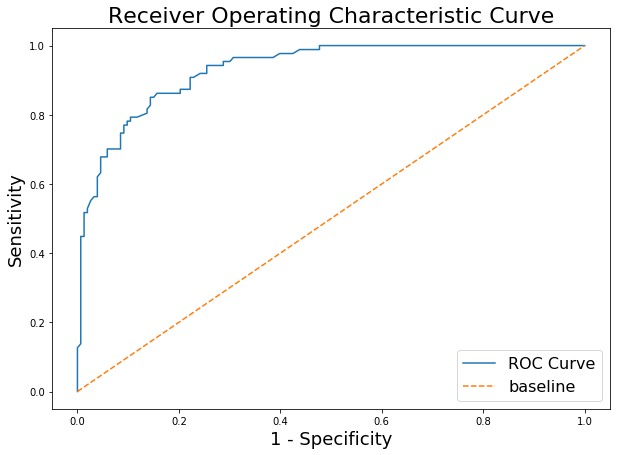

In [60]:
## Code Was adopted from DSI-7 lecture 4.02
plt.figure(figsize=(10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 500)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df1, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df1, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 500),
         np.linspace(0, 1, 500),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [61]:
roc_auc_score(pred_df1['true_values'], pred_df1 ['pred_probs'])

0.9312598602659454

## Try fitting Random Forrest Classifier

In [62]:
# rfc=RandomForestClassifier(random_state=42)
# rfc_params={
#     'n_estimators':[40, 50],
#     'max_depth':[None, 3,4,5],
#     'max_features':['auto', 4, 5],  # default is sqrt(9)= 3 features per tree
#     'min_samples_split':[3, 5, 7]
    
# }
# gs=GridSearchCV(rfc, param_grid=rfc_params, cv=5)
# # Trying our all param combinations, 
# # for each combo, we'r doing a 5 fold cv
# # use the best params and fit to the entire training data
# gs.fit(X_train, y_train)
# print (gs.best_score_) # Cross val score: 0.8286908077994429 from best_params_
# gs.best_params_ # best parameters: {'max_depth': None,
                  #                   'max_features': 'auto',
                  #                   'min_samples_split': 5,
                  #                   'n_estimators': 50}

In [63]:
rfc1 = RandomForestClassifier(random_state=42, max_depth=4, min_samples_split=3, n_estimators=40)
rfc1.fit(X_train, y_train)
print(f'Random Forest Train Score: {rfc1.score(X_train, y_train)}')  # Achieved Accuracy
print(f'Random Forest Test Score: {rfc1.score(X_test, y_test)}')

Random Forest Train Score: 0.8927576601671309
Random Forest Test Score: 0.8541666666666666


In [64]:
preds02 = rfc1.predict(svd_df)
preds32 = rfc1.predict(svd_df3)
df['preds02'] = preds02
df3['preds32'] = preds32

In [65]:
# Compute F1 scores, weighted average of the precision and recall
print(f'Total Score: { f1_score(preds02, y)}')  # F1 score for flood relevance
print(f'Total Score: { f1_score(preds32, y3)}') # F1 score for flood articles

Total Score: 0.838150289017341
Total Score: 0.5625


In [66]:
cm02 = confusion_matrix(y, preds02)
cm_df02 = pd.DataFrame(cm02, columns=['pred_neg', 'pred_pos'],
                       index=['actual_neg', 'actual_pos'])
cm_df02

,pred_neg,pred_pos
actual_neg,556,54
actual_pos,58,290


In [67]:
tn, fp, fn, tp = confusion_matrix(y, preds02).ravel()
(tn, fp, fn, tp)
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.8430232558139535
recall:  0.8333333333333334


In [68]:
cm32 = confusion_matrix(y3, preds32)
cm_df32 = pd.DataFrame(cm32, columns=['pred_neg', 'pred_pos'],
                       index=['actual_neg', 'actual_pos'])
cm_df32

,pred_neg,pred_pos
actual_neg,104,14
actual_pos,0,9


In [69]:
tn, fp, fn, tp = confusion_matrix(y3, preds32).ravel()
(tn, fp, fn, tp)
print('precision: ',(tp/(tp+fp)))
print('recall: ',(tp/(tp+fn)))

precision:  0.391304347826087
recall:  1.0


In [70]:
df3[(df3['preds32'] == 1) & (df3['flood_disaster_relevance'] == 0)]

,index,content,description,publishedAt,title,source_name,flood_disaster_relevance,preds3,preds31,preds32
0,0,Image copyright EPA Image caption Locals have ...,Cyclone Owen has been downgraded to a tropical...,2018-12-15T23:02:13Z,"Cyclone Owen downgraded, but could reform off ...",BBC News,0,1,1,1
3,3,Image copyrightAFPImage caption\r\n A man inju...,The tropical cyclone took governments by surpr...,2019-03-24T00:23:07Z,Cyclone Idai: How prepared was southern Africa?,BBC News,0,1,1,1
7,8,Image copyrightEPAImage caption\r\n The town o...,Rescue workers struggle to reach remote parts ...,2019-03-17T12:43:35Z,Indonesia floods: Dozens dead in Papua province,BBC News,0,1,1,1
19,20,Image copyright South Wales Police Image capti...,Police urge motorists to take care following a...,2018-11-07T21:55:06Z,Weather warning as car plunges into south Wale...,BBC News,0,0,1,1
28,30,Media caption Milford Haven was one of the are...,Heavy rain and flooding is expected on Friday ...,2018-11-09T12:55:40Z,Flooding hits roads and homes in Pembrokeshire...,BBC News,0,1,1,1
29,31,Image caption Houses in Llanelli suffered floo...,"When the deluge came down, one coastal town es...",2018-11-28T14:41:18Z,How Llanelli avoided flooding during Storm Callum,BBC News,0,0,1,1
38,41,Image copyrightReuters\r\nA stranded motorist ...,A stranded motorist in Mozambique tells of the...,2019-03-22T13:04:55Z,Cyclone Idai: 'We saw 200 bodies by the roadside',BBC News,0,1,0,1
50,53,Image copyright Met Office Image caption The M...,The remnants of Hurricane Oscar have caused a ...,2018-11-03T12:32:09Z,Flood warnings issued for parts of Scotland,BBC News,0,0,1,1
53,57,"VideoThousands of people in Sulawesi, Indonesi...",Thousands of people are being evacuated as fla...,2019-01-25T07:31:01Z,Indonesia flash flood sweeps away entire longh...,BBC News,0,1,0,1
63,67,Image copyrightReutersImage caption\r\n Women ...,The number of cases of the disease has almost ...,2019-04-01T14:38:17Z,Cyclone Idai: First cholera death in Mozambiqu...,BBC News,0,1,1,1


In [71]:
df3.iloc[101,1]

'Image caption\r\n Fairground rides were affected in Dumfries as flood waters flowed into the Whitesands\r\nHeavy overnight rain and high winds have been causing problems across Scotland ahead of Storm Gareth.\r\nA Met Office warning of possible travel disruption is in place from  :  on Tuesday until  :  on Wednesday covering a swathe of the west coast.\r\nFlooding has already affected many parts of the country with alerts in place in southern and western areas.\r\nThere is also widespread disruption on ferries with a number of services cancelled or facing disruption.\r\nStrong west to northwesterly winds are expected until Wednesday afternoon with the Met Office saying bus and train services could be affected.\r\nShort-term loss of power and other services are also possible.\r\nImage caption\r\n The level of the River Nith has risen ahead of the warning for Storm Gareth\r\nA number of areas have already been hit by flooding or strengthening winds.\r\nIn Dumfries, the Whitesands area w

## Summary:  confusion matrices

In [72]:
# kNN with k=7 on Flood Relevance
cm_df

,pred_neg,pred_pos
actual_neg,549,61
actual_pos,78,270


In [73]:
# Bagged of Decision Trees on Flood Relevance
cm_df01

,pred_neg,pred_pos
actual_neg,564,46
actual_pos,82,266


In [74]:
# Random Forrest Classifier on Flood Relevance
cm_df02

,pred_neg,pred_pos
actual_neg,556,54
actual_pos,58,290


In [75]:
# kNN with k=7 on Flood Articles
cm_df3

,pred_neg,pred_pos
actual_neg,108,10
actual_pos,0,9


In [76]:
# Bagged Decision Trees on Flood Articles
cm_df31

,pred_neg,pred_pos
actual_neg,105,13
actual_pos,0,9


In [77]:
# Random Forest Classifier on Flood Articles
cm_df32

,pred_neg,pred_pos
actual_neg,104,14
actual_pos,0,9


## Scatterplot of selected components on Articles  Dataset (SVD_df3) 

In [78]:
svd_df3c['preds'] = preds3

In [79]:
svd_df3c.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,preds
0,0.239293,0.090569,-0.040467,-0.038120,-0.019326,-0.021398,0.018319,-0.014187,-0.015235,0.001726,...,0.031788,-0.011673,0.022609,-0.024179,-0.009037,0.013185,-0.000381,-0.001727,0.044531,1
1,0.126211,-0.000837,-0.050894,-0.063046,-0.018469,-0.030258,0.017673,-0.007006,0.003743,-0.006019,...,-0.038182,0.009187,0.000263,0.015878,-0.011217,0.032179,0.009951,-0.019282,-0.007620,0
2,0.223225,-0.082331,-0.097539,-0.119526,-0.066894,-0.066701,0.033703,-0.010850,0.004964,-0.032958,...,-0.027449,0.023091,-0.018197,-0.038260,-0.029152,0.017736,-0.003019,-0.039695,0.015348,0
3,0.235153,-0.010210,-0.092211,-0.093262,-0.025146,-0.043776,0.001470,-0.006067,-0.016245,-0.024396,...,0.018823,-0.002485,0.000835,-0.027099,-0.004025,0.000396,-0.015071,0.016626,0.031077,1
4,0.264596,-0.053239,-0.127797,-0.119430,-0.063109,-0.067272,-0.005702,-0.039083,0.007259,0.003880,...,-0.017893,0.006374,0.027191,-0.007115,0.016203,-0.042977,-0.005661,0.002965,0.062976,1


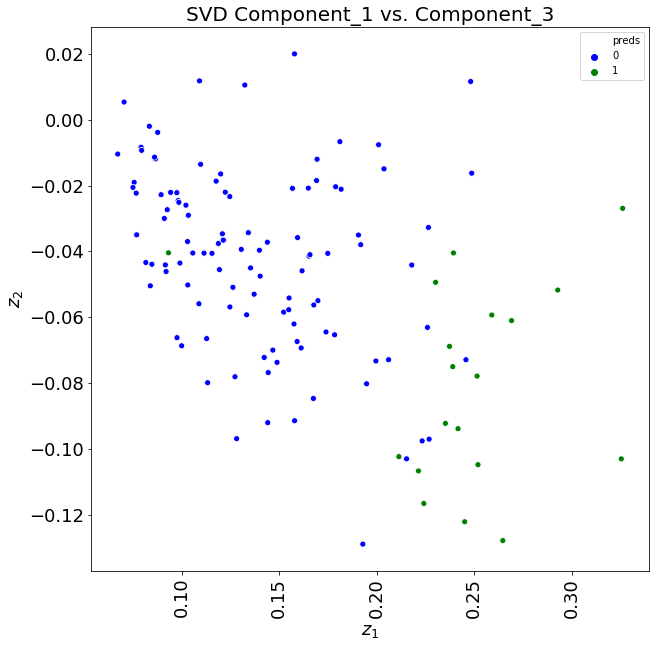

In [80]:
colors = ("blue", "green")
plt.figure(figsize=(10,10))
sns.scatterplot (data=svd_df3c , x='component_1', y='component_3', hue='preds', palette=["b", "g"])
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('SVD Component_1 vs. Component_3', fontsize=20)
plt.savefig ('SVD_components.png')